In [1]:
from flame_analysis_model import *
from mpi4py import MPI
import matplotlib.pyplot as plt

In [2]:
comm = MPI.COMM_WORLD
rank = comm.rank

time_step = 212
phi = 0.40
lat_size = 100
T_ref = 300
p_ref = 5e05


folder_name = f"data/phi{phi:.2f}/h400x{lat_size}_ref"
file_name = "premix"

# Communicator for parallelization
comm = MPI.COMM_WORLD

# 2) Load dataset
scalars = [
    'H2','O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
    'curvature', 'stretch_rate', 'disp_speed_density_weighted',
    'abs_flame_prop_vel_normal', 'flow_velocity_normal',
    'flow_velocity_tangential', 'tangential_strain_rate',
    'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
    'vorticity'
]

ds = SEMDataset(file_name=file_name, folder_name= folder_name,time_step= time_step, comm=MPI.COMM_WORLD, scalar_names=scalars)
df = ds.create_dataframe(
    compute_vel_jacobian= False,
    compute_vel_hessian= False,
    compute_reaction_rates= True,
    cantera_inputs = ["../chemical_mech/BurkeH2.yaml", None, phi, T_ref, p_ref]
)
df.to_csv(f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref/extracted_flame_front_{time_step}.csv", index=False )

2025-12-03 12:07:01,280 - Mesh - INFO - Initializing empty Mesh object.
2025-12-03 12:07:01,281 - Field - INFO - Initializing empty Field object
2025-12-03 12:07:01,281 - pynekread - INFO - Reading file: ../data/phi0.40/h400x100_ref/premix0.f00001
2025-12-03 12:07:01,337 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-12-03 12:07:01,339 - Mesh - INFO - Initializing common attributes.
2025-12-03 12:07:01,339 - Mesh - INFO - Getting vertices
2025-12-03 12:07:01,346 - Mesh - INFO - Getting edge centers
2025-12-03 12:07:01,445 - Mesh - INFO - Facet centers not available for 2D
2025-12-03 12:07:01,446 - Mesh - INFO - Mesh object initialized.
2025-12-03 12:07:01,447 - Mesh - INFO - Mesh data is of type: float64
2025-12-03 12:07:01,448 - Mesh - INFO - Elapsed time: 0.11077769999974407s
2025-12-03 12:07:01,448 - pynekread - INFO - Reading field data
2025-12-03 12:07:01,449 - pynekread - INFO - Overwriting fld object
2025-12-03 12:07:01,765 - pynekread - INFO - File read
2025

In [3]:
c = 3.5
front = ds.extract_flame_front_unstruct(
    c_level= c,
)
print(front.head())
front.to_csv(f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref/extracted_flame_front_{time_step}_iso_{c}.csv", index=False )

            x          y    z         v    T        H2        O2       H2O  \
0  204.899797  56.503330  0.0  2.559427  3.5  0.002390  0.169386  0.071223   
1  204.926362  56.451614  0.0  2.533177  3.5  0.002411  0.169404  0.071259   
2  204.847432  56.616249  0.0  2.618043  3.5  0.002334  0.169651  0.071001   
3  204.851303  56.607220  0.0  2.612714  3.5  0.002340  0.169652  0.071007   
4  204.800003  56.762884  0.0  2.701187  3.5  0.002226  0.169784  0.070797   

          H         O  ...     omega_O2    omega_H2O     omega_H    omega_O  \
0  0.000058  0.000580  ... -8031.418454  2236.734188 -198.150774 -21.459188   
1  0.000059  0.000585  ... -8170.330690  2281.878160 -201.118148 -19.735738   
2  0.000055  0.000544  ... -7811.928395  2141.011279 -195.118753 -28.902680   
3  0.000055  0.000544  ... -7837.523165  2147.465324 -195.821853 -29.123327   
4  0.000051  0.000524  ... -7286.609250  1985.174210 -182.647737 -28.982064   

     omega_OH    omega_HO2  omega_H2O2  omega_N2        

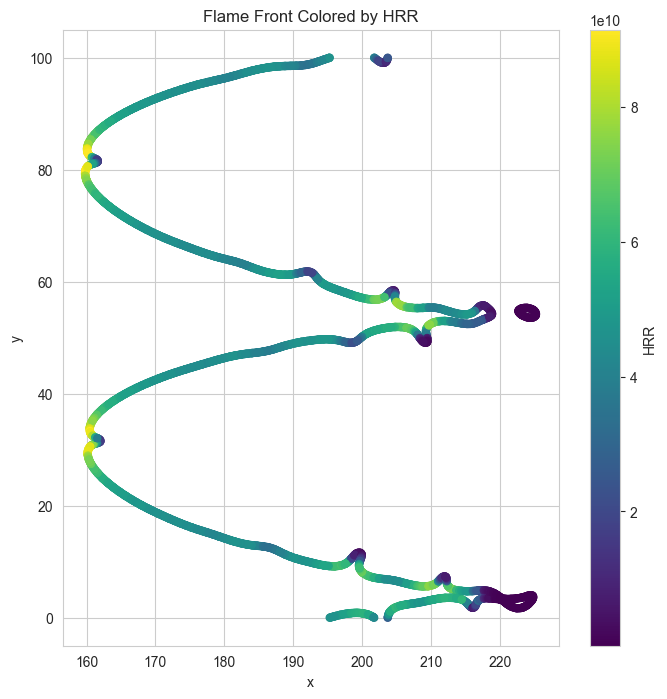

In [4]:
plot_var = "HRR"
plt.figure(figsize=(8, 8))

sc = plt.scatter(
    front["x"],
    front["y"],
    c = front[plot_var],
    cmap = "viridis",
    linewidths= 1e-2
)
plt.colorbar(sc, label=plot_var)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Flame Front Colored by {plot_var}")
plt.show()


C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\pandas\core\series.py:1036: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


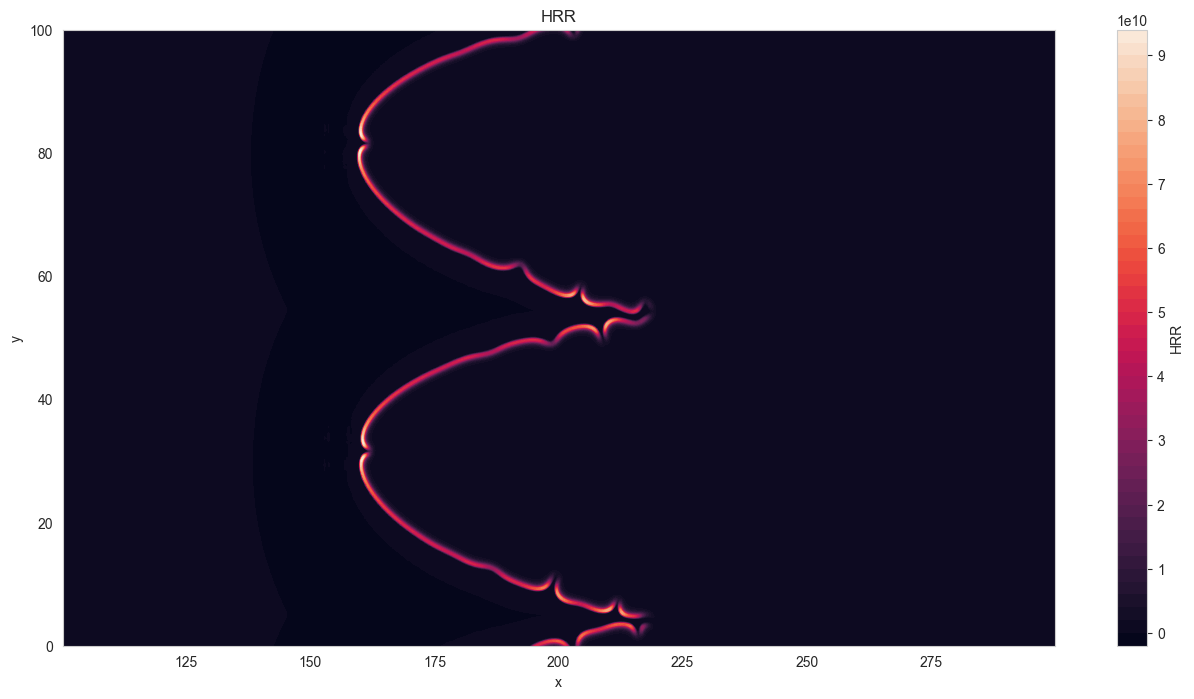

In [5]:
df_sub = df[(df["x"]>100)& (df["x"]<300)]
plt.figure(figsize=(16, 8))
cf = plt.tricontourf(
    df_sub["x"], df_sub["y"], df_sub[plot_var],
    levels=50,
)
plt.xlabel("x")
plt.ylabel("y")
plt.title(str(plot_var))  # instead of empty f""
plt.colorbar(cf, label=plot_var)
plt.show()


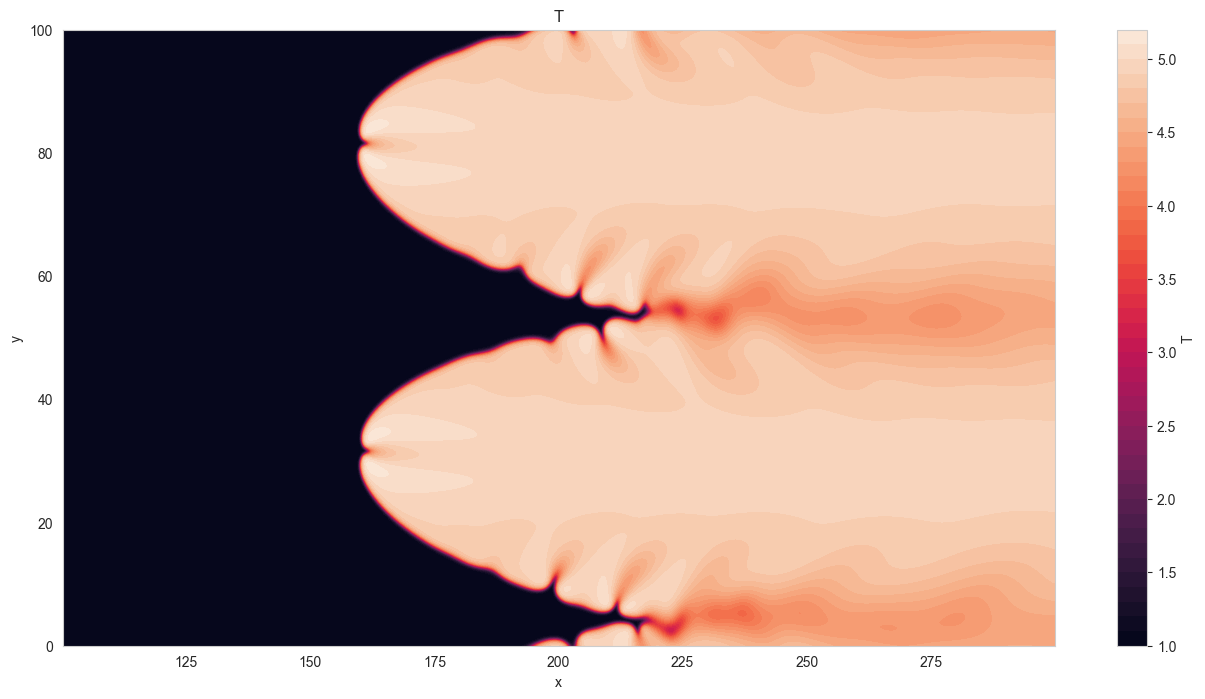

In [6]:
plot_var = "T"
plt.figure(figsize=(16, 8))
cf = plt.tricontourf(
    df_sub["x"], df_sub["y"], df_sub[plot_var],
    levels=50,
)
plt.xlabel("x")
plt.ylabel("y")
plt.title(str(plot_var))  # instead of empty f""
plt.colorbar(cf, label=plot_var)
plt.show()